# Imports

In [1]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [2]:
import torch
import matplotlib.pyplot as plt

In [3]:
import matplotlib
matplotlib.rcParams['figure.facecolor'] = 'white'

In [4]:
import pandas as pd
pd.options.display.max_columns = None

# Load model

In [3]:
%run ../models/checkpoint/__init__.py

In [5]:
run_name = '1215_174443_cxr14_resnet-50-v2_lr0.0001_os_Cardiomegaly_normS_size256_sch-roc_auc-p5-f0.1'
debug_run = False

In [6]:
compiled_model = load_compiled_model_classification(run_name, debug=debug_run)
compiled_model.metadata['model_kwargs']

{'model_name': 'resnet-50-v2',
 'labels': ['Cardiomegaly'],
 'imagenet': True,
 'freeze': False,
 'gpool': 'avg',
 'fc_layers': []}

# Load data

In [5]:
%run ../datasets/__init__.py

In [6]:
dataset_kwargs = {
    'dataset_name': 'cxr14',
    'dataset_type': 'all',
    'max_samples': None,
}
dataloader = prepare_data_classification(**dataset_kwargs)
dataset = dataloader.dataset
len(dataset)

112120

# Apply CLAHE normalization to images

In [7]:
import os
import numpy as np
from skimage.exposure import equalize_adapthist
from PIL import Image

## Apply to one sample

In [45]:
idx = 30

In [46]:
image_fname = dataset.label_index['FileName'][idx]
fpath = os.path.join(dataset.image_dir, image_fname)

In [70]:
%%time

image = Image.open(fpath)
image_np = np.array(image)
image_2 = equalize_adapthist(image_np)
image_3 = (image_2 * 255).astype(np.uint8)

# Try with RGB # result --> is the same!!
# image = Image.open(fpath).convert('RGB')
# image_4 = equalize_adapthist(np.array(image))
# image_4 = (image_4 * 255).astype(np.uint8)

image_np.shape, image_2.shape, image_3.shape # , image_4.shape

CPU times: user 86.5 ms, sys: 15.9 ms, total: 102 ms
Wall time: 101 ms


((1024, 1024), (1024, 1024), (1024, 1024))

In [71]:
image_2.dtype

dtype('float64')

In [77]:
image_2.min(), image_2.max()

(0.0, 1.0)

(-0.5, 1023.5, 1023.5, -0.5)

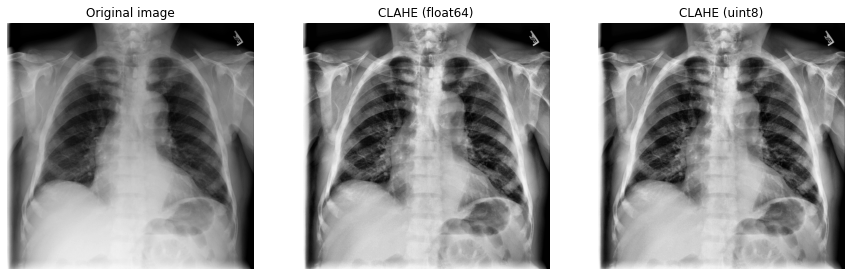

In [69]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title('Original image')
plt.imshow(image_np, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('CLAHE (float64)')
plt.imshow(image_2, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('CLAHE (uint8)')
plt.imshow(image_3, cmap='gray')
plt.axis('off')

In [45]:
image_np.min(), image_np.max(), image_2.min(), image_2.max(), image_3.min(), image_3.max()

(0, 255, 0.0, 1.0, 0, 255)

In [50]:
image_np.dtype, image_2.dtype, image_3.dtype

(dtype('uint8'), dtype('float64'), dtype('uint8'))

## Apply to the whole dataset

In [8]:
from tqdm.auto import tqdm
from collections import defaultdict

In [9]:
image_fnames = list(dataset.label_index['FileName'])
len(image_fnames)

112120

In [ ]:
%%time

clahe_folder = dataset.image_dir + '-clahe'
wrong_images = defaultdict(list)

for image_fname in tqdm(image_fnames):
    fpath = os.path.join(dataset.image_dir, image_fname)

    image = Image.open(fpath).convert('L')
    image = np.array(image)
    if image.ndim != 2:
        wrong_images['n-dim-not-2'].append(image_fname)
        continue
    
    image = equalize_adapthist(image)
    image = (image * 255).astype(np.uint8)
    
    new_fpath = os.path.join(clahe_folder, image_fname)
    
    if os.path.isfile(new_fpath):
        raise Exception(f'Overriding previous file at {new_fpath}')

    image = Image.fromarray(image, mode='L')
    image.save(new_fpath)

  0%|          | 0/112120 [00:00<?, ?it/s]

In [29]:
image.dtype, image_2.dtype

(dtype('uint8'), dtype('uint8'))

In [35]:
image.nbytes == image_2.nbytes, image.nbytes, image_2.nbytes

(False, 1048576, 3145728)

In [32]:
image = Image.open(fpath)
image = np.array(image)
image.dtype

dtype('uint8')

In [33]:
image.nbytes

1048576

In [22]:
new_fpath

'/mnt/workspace/chest-x-ray-8/dataset/images-clahe/00000001_000.png'

In [20]:
image.mode

'RGB'

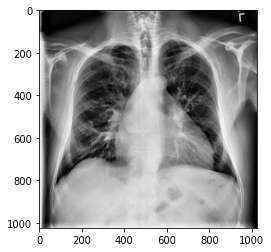

In [17]:
plt.imshow(image)